In [1]:
# default_exp exp.i

# Exploration of your data

> This module comprises all the statistical and inference techniques to describe the inner properties of software data. The submodules might include:
>
> - Descriptive statistics
> - Software Metrics
> - Information Theory
> - Learning Principels Detection (Occams' Razor, Biased data, and Data Snooping)
> - Inference: Probabilistic and Causal

In [2]:

# Imports
import pandas as pd
import sentencepiece as sp
import dit

from collections import Counter
from scipy.stats import sem, t
from numpy import mean
from numpy import std
import statistics as stat
import matplotlib.pyplot as plt


# TODO: Remove when mongo call is implemented
import os

In [3]:

from nbdev.showdoc import *

# MOVED NECESSARY PIECES TO 08

In [4]:
# TODO: Replace with actual mongo call
def simulate_getting_dataframes_from_mongo():
    corpus_data = {'file_name': [], 'data_type': [], 'contents': []}
    path = "./test_data/LibEST_semeru_format/requirements"
    for file in os.listdir(path):
        corpus_data['file_name'].append(file)
        corpus_data['data_type'].append('req')
        with open (os.path.join(path, file), "r") as f:
            corpus_data['contents'].append(f.read())
    path = "./test_data/LibEST_semeru_format/source_code"
    for file in os.listdir(path):
        corpus_data['file_name'].append(file)
        corpus_data['data_type'].append('src')
        with open (os.path.join(path, file), "r") as f:
            corpus_data['contents'].append(f.read())
    path = "./test_data/LibEST_semeru_format/test"
    for file in os.listdir(path):
        corpus_data['file_name'].append(file)
        corpus_data['data_type'].append('test')
        with open (os.path.join(path, file), "r") as f:
            corpus_data['contents'].append(f.read())
    corpus_df = pd.DataFrame(data = corpus_data)
    return corpus_df

In [5]:
#Hide
#This isn't actually used so we don't need to test it but here you can see how a data frame is organized
df = simulate_getting_dataframes_from_mongo()

df

,file_name,data_type,contents
0,RQ1.txt,req,REQUIREMENT 1\n \nThis document profiles c...
1,RQ10.txt,req,REQUIREMENT 10: SERVER KEY GENERATION\n \n...
2,RQ11.txt,req,REQUIREMENT 11: FULL PKI REQUEST MESSAGES\n ...
3,RQ13.txt,req,REQUIREMENT 13: PROTOCOL DESIGN AND LAYERING\n...
4,RQ14.txt,req,REQUIREMENT 14: APPLICATION LAYER\n \nThe ...
5,RQ15.txt,req,REQUIREMENT 15: HTTP LAYER\n \nHTTP is use...
6,RQ16.txt,req,REQUIREMENT 16: HTTP HEADERS FOR CONTROL\n ...
7,RQ17.txt,req,REQUIREMENT 17: HTTP URIS FOR CONTROL\n \n...
8,RQ18.txt,req,REQUIREMENT 18: HTTP-BASED CLIENT AUTHENTICATI...
9,RQ19.txt,req,REQUIREMENT 19: MESSAGE TYPES\n \nThis doc...


In [6]:

def df_to_txt_file(df, output, cols):
    """Converts a dataframe into a text file that SentencePiece can use to train a BPE model"""
    if cols is None: cols = list(df.columns)
    merged_df = pd.concat([df[col] for col in cols])
  
    with open(output + '_text.txt', 'w') as f:
        f.write('\n'.join(list(merged_df)))
    return output + '_text.txt'

In [ ]:

def gen_sp_model(df, output, model_name, cols=None):
    """Trains a SentencePiece BPE model from a pandas dataframe"""
    fname = df_to_txt_file(df, output, cols)
    sp.SentencePieceTrainer.train(f'--input={fname} --model_prefix={output + model_name} --hard_vocab_limit=false --model_type=bpe')
    return output + model_name

In [ ]:

def encode_text(text, model_prefix):
    '''Encodes text using a pre-trained sp model, returns the occurrences of each token in the text'''
    sp_processor = sp.SentencePieceProcessor()
    sp_processor.Load(f"{model_prefix}.model")
    token_counts = Counter()
    encoding = sp_processor.encode_as_pieces(text)
    for piece in encoding:
        token_counts[piece] += 1
    return token_counts

In [ ]:
#ExpTest

#This tests the encode text method assuming the sp model(?)

text = "For when you gaze long into the abyss, the abyss gazes also into you."
model_prefix = ""

In [10]:
#Notes: token_counts is a counter object.
def dit_shannon(token_counts):
    '''Takes in a counter object of token occurrences, computes the entropy of the corpus that produced it'''
    num_tokens = 0
    for token in token_counts:
        num_tokens += token_counts[token]
    outcomes = list(set(token_counts.elements()))
    frequencies = []
    for token in token_counts:
        frequencies.append((token_counts[token])/num_tokens)
    d = dit.ScalarDistribution(outcomes, frequencies)
    return dit.shannon.entropy(d)

In [22]:
#ExpTest
#This test takes a sample string and creates a counter that it runs dit shannon on to verify the shannon functionality
sample_txt = "Form does not differ from the void, and the void does not differ from the form. Form is the void, and the void is form"
sample_tcnt = Counter(sample_txt)

answer = dit_shannon(sample_tcnt)
expected = 3.7143246186742513
assert(answer == expected)
print(answer)
print(expected)
print(sample_tcnt)

3.7143246186742513
3.7143246186742513
Counter({' ': 24, 'o': 14, 'd': 10, 'e': 9, 'r': 8, 'i': 8, 'f': 8, 't': 7, 'm': 6, 'h': 5, 's': 4, 'n': 4, 'v': 4, 'F': 2, ',': 2, 'a': 2, '.': 1})


In [ ]:
def entropies_of_df_entries(df, col, model_prefix):
    '''Returns a list of the entropies of each entry in a dataframe column'''
    entropies = []
    for data in df[col]:
        token_counts= encode_text(data, model_prefix)
        entropies.append(dit_shannon(token_counts))
    return entropies

In [ ]:
# TODO: Finish this such that is finds the entropy of the entire corpus \
#       and preserves the individual token frequencies so that we can   \
#      compute the most common tokens

# def entropy_of_whole_corpus(df, col, model_prefix):
#     '''Returns a dictionary of the entropies of each token in a dataframe corpus'''
#     entropies = {}
#     token_counts = encode_text(pd.concat[col], model_prefix)
#     entropies.append(dit_shannon(token_counts))
#     return entropies

In [ ]:

# TODO: Do we need this function?
import math
def manual_shannon(token_freqs):
    sum = 0
    for i in token_freqs:
        sum += i * math.log(1/i, 2)
    return sum

In [ ]:

# TODO: Do we need this function?
def sort_token_data(token_data):
    return sorted(token_data.items() ,  key=lambda x: x[1]["Occurrences"])

# EXPLORATORY ANALYSIS

## LIBest Corpus

In [ ]:
# Create a dataframe of the requirements, source code and test case data for LIBest
# Create a sentencepiece model using the entire LIBest corpus
LIB_corpus_df = simulate_getting_dataframes_from_mongo()
LIB_model = gen_sp_model(LIB_corpus_df, output='LIBest', model_name='_sp_bpe_modal', cols=['contents'])

## Looking at Individual Files

In [ ]:
# Use the model to compute each file's entropy
LIB_entropies = entropies_of_df_entries(LIB_corpus_df, 'contents', LIB_model)

In [ ]:
# Calculate metrics on the LIBest corpus entropies
print("Max entropy:", max(LIB_entropies))
print("Min entropy:", min(LIB_entropies))
print("Average entropy:", mean(LIB_entropies))
print("Median entropy:", stat.median(LIB_entropies))

print("Entropy Standard Deviation:", std(LIB_entropies))

confidence = 0.95
n = len(LIB_entropies)
m = mean(LIB_entropies)
std_err = sem(LIB_entropies)
h = std_err * t.ppf((1 + confidence) / 2, n - 1)

start = m - h
end = m + h
print(f"95% of entropies fall within {start} and {end}")

Max entropy: 8.736686724450998
Min entropy: 3.9797975854871477
Average entropy: 6.9103334297633525
Median entropy: 7.086176924292343
Entropy Standard Deviation: 1.069417835431708
95% of entropies fall within 6.681088254680821 and 7.139578604845884


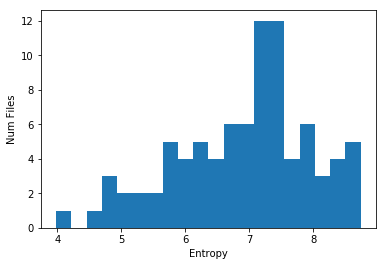

In [ ]:
# Create a histogram of the entropy distribution
plt.hist(LIB_entropies, bins = 20)
plt.ylabel("Num Files")
plt.xlabel("Entropy")
plt.show()

## Looking at the Corpus as a Whole